# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [4]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# 1. Camera calibration

Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [5]:
# Camera calibration code
def calibrate_camera(x, y, calibration_files):
    """
    Calculate camera matrix and distortion coefficients from chessboard images
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...
    objp = np.zeros((y*x,3), np.float32)
    objp[:,:2] = np.mgrid[0:x, 0:y].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob(calibration_files)
    shape = (None, None)

    # Step through the list of files and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        shape = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (x,y), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    return mtx, dist

def correct_distortion(img, mtx, dist):
    """
    Correct image distortion based on camera matrix and distortion coefficients
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

    

# 2. Still Image pipeline

## Perspective Transform

In [13]:
def get_transform_points(shape):
    """
    Get point for transformation matrix generation
    """
        
    src = np.float32([
        [shape[1]*.4396, shape[0]*.6389],
        [shape[1]*.1458, shape[0]],
        [shape[1]*.875,  shape[0]],
        [shape[1]*.5625, shape[0]*.6389]
    ])
    dst = np.float32([
        [shape[1]*.25, 0],
        [shape[1]*.25, shape[0]],
        [shape[1]*.75, shape[0]],
        [shape[1]*.75, 0]
    ])

    return src, dst

def perspective_transform(img, src, dst):
    """
    Warp image perspective
    """    
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)


## Lane Line Masking 
Thresholding functions related to masking

In [73]:


def abs_sobel_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """
    Apply sobel operator with thresholding.
    
    Return a mask with same size than the original image
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    #        is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    
    if img.ndim > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = (255*abs_sobel/np.max(abs_sobel)).astype(np.uint8)
    grad_binary = np.zeros_like(scaled_sobel)    
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1    
    return grad_binary

def mag_threshold(imag, sobel_kernel=3, thresh=(0, 255)):
    """
    Compute magnitude of gradient, and apply threshold
    
    Return a mask with same size than the original image
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scaled_gradmag = (255*gradmag/np.max(gradmag)).astype(np.uint8) 
    mag_binary = np.zeros_like(scaled_gradmag)
    mag_binary[(scaled_gradmag >= thresh[0]) & (scaled_gradmag <= thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    """
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= mag_thresh[0]) & (absgraddir <= mag_thresh[1])] = 1
    return dir_binary


def color_threshold(img, channel='R', thresh=(0,255)):
    """
    Threshold based on color channel RGB or HLS
    """
    if channel=='R':
        c = img[:,:,0]
    elif channel=='G':
        c = img[:,:,1]
    elif channel=='B':
        c = img[:,:,2]
    elif channel=='H':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,0] 
    elif channel=='L':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,1]
    elif channel=='S':
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        c = hls[:,:,2]
    elif channel=='V':
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        c = hsv[:,:,2]
    else:
        c = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    mask = np.zeros_like(c)
    mask[(c >= thresh[0]) & (c <= thresh[1])] = 1
    return mask

def do_thresholding(img, strategy):
    """
    Fixed tresholding tasks for an image
    """

    mask = np.zeros_like(img[:,:,0])

    if strategy == 0:
        rgb = color_threshold(img, 'R', (190,255))
        rgb = rgb & color_threshold(img, 'G', (190,255)) 
        rgb = rgb & color_threshold(img, 'B', (0,155))
        sobel = abs_sobel_threshold(img, 'x', 17, (40,180))
        luminance = color_threshold(img, 'L', (200,245))
        mask[(sobel==1) | (luminance==1) | (rgb==1)] = 1
    elif strategy == 1:
        rgb = color_threshold(img, 'B', (200,255))
        sat = color_threshold(img, 'S', (160,255))
        sobel = abs_sobel_threshold(img, 'x', 17, (40,180))
        mask[(sat==1) | (rgb==1) | (sobel==1)] = 1
    elif strategy == 2:
        rgb = color_threshold(img, 'R', (200,255))
        rgb = rgb & color_threshold(img, 'G', (200,255)) 
        rgb = rgb & color_threshold(img, 'B', (200,255))
        # A little bit adaptive strategy here. If image is too bright, then use smaller ranges
        # TODO: adaptive thresholding
        bri = color_threshold(img, 'V', (168,255))
        if np.sum(bri)> 100000:
            bri = color_threshold(img, 'V', (200,255))
            
        mask[(bri==1) | (rgb==1)] = 1


    return mask


## Line Finding Functions

In [23]:
from scipy import ndimage

def find_line_positions(mask, hist):
    """
    Find lane line positions (approximate) from a mask
    Note: a strong assumption is made that left line is on the left half of the mask
    and right on the right half
    """
    max_left = np.argmax(hist[:np.int(len(hist)/2)])
    max_right = np.argmax(hist[np.int(len(hist)/2):]) + np.int(len(hist)/2)

    left_left = [i for i in range(max_left) if hist[i] <hist[max_left]/10]
    left_right = [i for i in range(max_left,np.int(len(hist)/2)) if hist[i] <hist[max_left]/10]
    
    right_right = [i for i in range(max_right,len(hist)) if hist[i] <hist[max_right]/10]
    right_left = [i for i in range(np.int(len(hist)/2), max_right) if hist[i] <hist[max_right]/10]
    
    if len(left_left) > 0:
        left_left_border = left_left[len(left_left)-1]
    else:
        left_left_border = 0
    if len(left_right) > 0:
        left_right_border = left_right[0]
    else:
        left_right_border = np.int(len(hist)/2)
        
    if len(right_left) > 0:
        right_left_border = right_left[len(right_left)-1]
    else:
        right_left_border = np.int(len(hist)/2)+1
        
    if len(right_right) > 0:
        right_right_border = right_right[0]
    else:
        right_right_border = len(hist)-1
    
    # centers of mass
    left_com = ndimage.measurements.center_of_mass(hist[left_left_border:left_right_border])[0] + left_left_border
    right_com = ndimage.measurements.center_of_mass(hist[right_left_border:right_right_border])[0] + right_left_border

    left_com = np.round(left_com).astype('int')
    right_com = np.round(right_com).astype('int')
    
    return [left_left_border, left_right_border, left_com], [right_left_border, right_right_border, right_com]

def slide_border(ob, limit, hist, th):
    """
    Slide window border to point where value is just below threshold
    ob: old border, starting point
    limit: direction (0 to left, hist size to right)
    hist: window histogram
    th: threshold
    """
    hist_center = np.int(len(hist)/2)
    
    if hist[ob] < th:
        nb = hist_center
        if ob < hist_center:
            step = 1
        else:
            step = -1        
        for i in range(ob,hist_center,step):
            if hist[i] >= th:
                nb = i
                break
    else:
        nb = limit
        if ob < limit:
            step = 1
        else:
            step = -1 
        for i in range(ob,limit,step):
            if hist[i] < th:
                nb = i
                break                
    return nb

def next_window_position(line, lane, mask):
    """
    Calculate new sliding window position based
    line: previous window, triple: left border, right border, center of mass
    lane: horizontal slice of the image
    mask: bitmap containing line markings
    """
    left = line[0]
    right = line[1]
    com = -1
    
    #print("left", left, "right", right, "com", com)
    
    img_wid = mask.shape[1]-1
    # this constant tells, how much we peek from left and right from the previous window
    # if it is too large, there is a danger, that we get other features tracked
    # if it is too small, we may not catch the line feature when the line is curvy enough
    #peek = 25
    peek = 30
    
    win_left = max(left - peek, 0)
    win_right = min(right + peek, img_wid)
    win_wid = win_right - win_left
    
    # take histogram using previous window and new window slice
    window = mask[lane[0]:lane[1],win_left:win_right]
    hist = np.sum(window, axis=0)
    
    win_center = np.int(win_wid/2)

    #print("win left", win_left, "win_right", win_right)
    
    max_val = np.argmax(hist)
    threshold = np.int(hist[max_val]/8)
    
    #print("ind max", max_val, "max val", hist[max_val], "threshold", threshold, hist.shape)
    offset = 0
    
    if hist[max_val] > 9: # FIXME: threasholding parameter 
    #if hist[max_val] > 15: # FIXME: threasholding parameter 
        # slide window if peak is off from center
        offset = win_center - max_val
        win_left = max(0, win_left - offset)
        win_right = min(win_right - offset, img_wid)
        win_wid = win_right - win_left
        window = mask[lane[0]:lane[1], win_left:win_right]
        hist = np.sum(window, axis=0)
        
        left  = slide_border(0, 0, hist, threshold) + win_left
        right = slide_border(win_wid-1, len(hist), hist, threshold) + win_left

        COM = ndimage.measurements.center_of_mass(hist)[0]
        if COM == COM:
            com = np.int(np.round(COM)) + win_left
        else:
            com = -1
    
    #print("Max at:", max_val, "Win center:", win_center, "Peak offset:", offset, "Threshold:", threshold,
    #      "Win left:", left, "Win right:", right, "Center of mass:", com)
    
    return [left, right, com]



def find_lines(img, left_line, right_line):
    """
    """
            
    # TODO 
    shape = img.shape
    
    lane = np.array([630,720]) # img slice

    right_win = np.zeros((8,3),dtype='int')
    left_win = np.zeros((8,3),dtype='int')

    right_prev = right_line
    left_prev = left_line

    for i in range(8):
    
        h = np.sum(img[lane[0]:lane[1],40:1240], axis=0) 
    
        right_win[i] = next_window_position(right_prev, lane, img[:,40:1240])
        left_win[i] = next_window_position(left_prev, lane, img[:,40:1240])

        right_prev = right_win[i]
        left_prev = left_win[i]
        lane = lane - 90
        
    
        
    return left_win, right_win


## Lane Curvature and Car Position Calculation

In [94]:
def radius(left_points, right_points):
    """
    Calculate radius of the curvature. We take the average of left and right lane radius, which
    should be pretty much the same as radius of the center of the lane
    """
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    points = (left_points + right_points)/2
    
    # Fit new polynomials to x,y in world space
    coeffs = np.polyfit(points[:,1]*ym_per_pix, points[:,0]*xm_per_pix, 2)

    y_eval = points[len(points)-1,1]*ym_per_pix
    curverad = ((1 + (2*coeffs[0]*y_eval + coeffs[1])**2)**1.5) / np.absolute(2*coeffs[0])
    
    if coeffs[0] < 0:
        curverad *= -1
        
    return curverad

def vehicle_offset(left_border, right_border):
    """
    Calculate vechicle offset from the center of the lane
    """

    # FIXME: assumed 1280 width
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    pos = ((right_border - left_border)/2 + left_border)
    pix_offset = 640.0 - pos
        
    m_offset = pix_offset * xm_per_pix
    
    return m_offset


## Polynomial Fitting
Line fitting and lane overlay generation

In [16]:
def get_fit_data(sliding_win):
    """
    Extracts fit data from sliding windows
    Note: windows are handled in reverse order
    
    TODO: image size!
    """
    line_fit = np.empty((0,2), dtype='int')
    
    for i in range(7,-1,-1):
        if sliding_win[i,2] > 0:
            y = 675 - 90 * i
            x = sliding_win[i,2]
            line_fit = np.append(line_fit, [[x,y]], axis=0)
   
    return line_fit

def get_avg_dist(left, right):

    dist = np.zeros(len(right), dtype='int')
    
    for r,l,i  in zip(right, left, range(8)):
        if r > 0 and l > 0:
            dist[i] = r-l
            
    avg = np.round(np.average(dist,weights=(dist>0))).astype('int')
    
    return avg

def fit_poly(line, yvals):
    """
    """
    
    # fit the line data to second order polynomial 
    coef = np.polyfit(line[:,1], line[:,0], 2)
    
    # use polynomial coefficients to calculate desired line points
    line_points = np.zeros((len(yvals),2), dtype='int')    
    line_points[:,0] = np.round(np.polyval(coef,yvals)).astype('int')
    line_points[:,1] = yvals
    
    return line_points, coef
    
def make_lane_overlay(mask, left, right, src, dst):
    """
    Create overlay with lane marking
    """
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(mask).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left[:,0], left[:,1]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right[:,0], right[:,1]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    overlay = perspective_transform(color_warp, dst, src)

    return overlay


def do_polynomial_fitting(win):
    """
    Do polynomial fitting
    """
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    fit_data = get_fit_data(win)

    yvals=np.array([0,90,180,270,360,450,540,630,720]) # TODO dimensions!

    line_points, coeffs = fit_poly(fit_data, yvals)
    
    return line_points, coeffs


## Image Processing Pipeline

In [75]:
def still_image_pipeline(img, mtx, dist):
    """
    Lane line finding pipeline

    Input: 
        1. original rgb image
        2. camera matrix
        3. distortion coefficients
        
    Output: 
        1. modified image with lane overlay
        2. lane curvature estimation
        3. vehicle position estimation
    """
    
    curvature = 0.0
    position = 0.0
    
    # Apply a distortion correction to raw images.
    img = correct_distortion(img, mtx, dist)
    shape = img.shape
    
    src, dst = get_transform_points(shape)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    warped = perspective_transform(img, src, dst)

    mask = do_thresholding(warped, 1)

    histogram = np.sum(mask[np.int(shape[0]/2):shape[0]-20,40:shape[1]-40], axis=0)
    left_line, right_line = find_line_positions(mask, histogram)
    
    left_win, right_win = find_lines(mask, left_line, right_line)
     
    left_line_points, left_coeffs = do_polynomial_fitting(left_win)
    right_line_points, right_coeffs = do_polynomial_fitting(right_win)

    left_line_points[:,0] = left_line_points[:,0] + 40
    right_line_points[:,0] = right_line_points[:,0] + 40
    
    # Warp the detected lane boundaries back onto the original image.
    overlay = make_lane_overlay(mask, left_line_points, right_line_points, src, dst)
    
    result = cv2.addWeighted(img, 1, overlay, 0.3, 0)
    
    return result, left_line_points, right_line_points, mask, curvature, position

## Image Loop
This is where still image pipeline is looped through test images

In [42]:
# Do camera calibratin first
mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

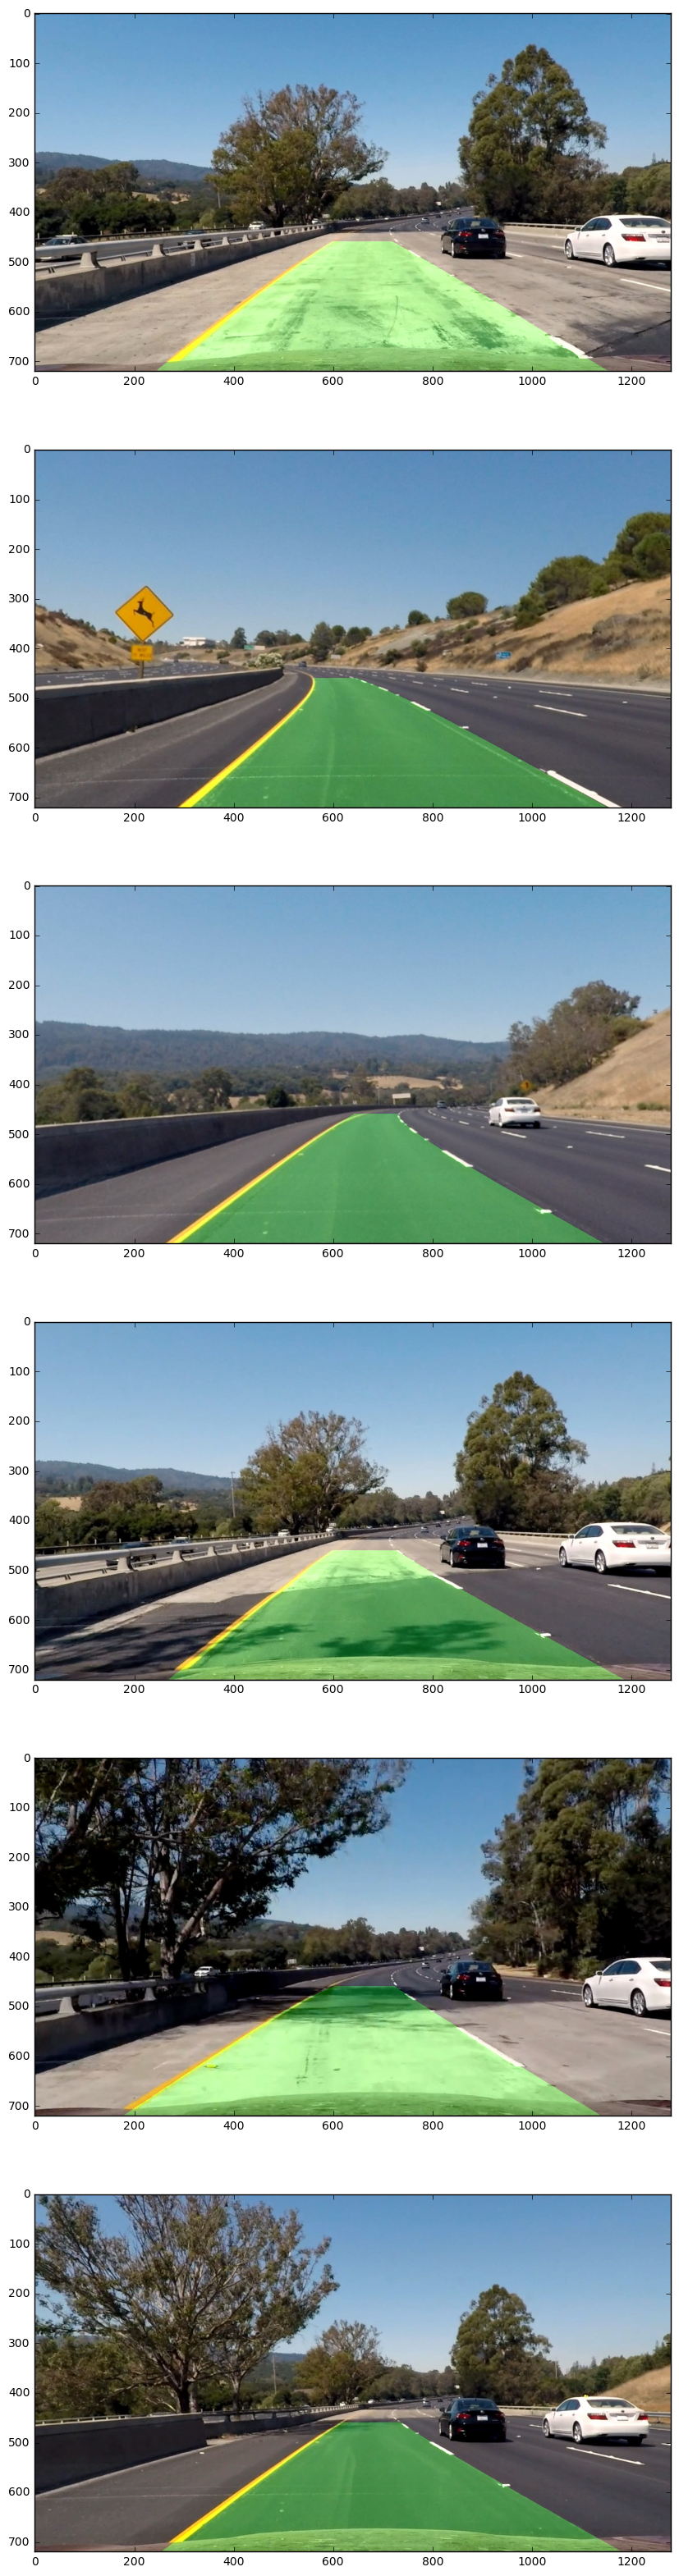

In [76]:
test_images = glob.glob('test_images/test*.jpg')

#fig, axes = plt.subplots(6, 1, figsize=(15,30))
fig, axes = plt.subplots(6, 1, figsize=(10,40))

for i, fname in zip(range(len(test_images)), test_images):
    img = mpimg.imread(fname);
    
    result, left_fit, right_fit, mask, curvature, position = still_image_pipeline(img, mtx, dist)
    
    #axes[i,0].imshow(img)
    #axes[i,0].axis('off')

    axes[i].imshow(result)
    #axes[i,1].axis('off')

    #axes[i,1].plot(left_fit[:,0], left_fit[:,1], 'o', color='red')
    #axes[i,1].plot(right_fit[:,0], right_fit[:,1], 'o', color='blue')
    #axes[i,1].set_xlim(0, 1280)
    #axes[i,1].set_ylim(0, 720)
    #axes[i,1].plot(left_fitx, left_fit[:,1], color='green', linewidth=3)
    #axes[i,1].plot(right_fitx, right_fit[:,1], color='green', linewidth=3)
    #axes[i,1].invert_yaxis() # to visualize as we do the images


    #sname = 'test_images/warped' + str(i) + '.jpg'
    #mpimg.imsave(sname, img2)

plt.show();
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/test_images_with_lane_overlays.png")

## 3. Video Pipeline Implementation

In [84]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

In [91]:
#
# Line class  
#

class Line():
    def __init__(self):
        # line is locked (it is good enough fit within n last frames)
        # TODO: currently line is never unlocked after first lock
        self.locked = False  
        # was the line detected in the last iteration?
        self.detected = False  
        # the last fit values of the line (window: left, right, center) for each examined slice
        self.recent_fit = []
        # average value of starting position for line finding over last 10 frames
        self.avg_fit = None  
        # average values of polynomial points over last 10 frames
        self.avg_points = None  
        # polynomial coefficients averaged over the last 10 iterations
        self.avg_coeffs = []
                
    def new_frame(self, win, recent_line):
        """
        Process line from a new lane
        """
        fits = [i for i in range(len(win)) if win[i,2] > 0]

        # FIXME: This sucks. Project video is better if we have 5 or more hits 
        # Challenge video is undoable unless the limit > 4. 
        # fits[0] < 3 selects the frame only if we have hits close to vehicle (which are of good quality)
        #if len(fits) > 4: 
        if len(fits) > 3 and fits[0] < 3: 
            # We require hit on 5 or more slice 
            self.detected = True
            line_points, coeffs = do_polynomial_fitting(win)
            # FIXME: this adjustment is because of earlier image cropping. 
            line_points[:,0] = line_points[:,0] + 40
            if not self.locked:
                self.locked = True
                self.recent_fit = win
                self.avg_points = line_points.astype('float64')
                self.avg_coeffs = coeffs
                if win[0,2] < 0:
                    self.avg_fit = np.array(recent_line, dtype='float64')
                else:
                    self.avg_fit = np.array(win[0], dtype='float64')
            else:
                self.avg_points[:,0] -= self.avg_points[:,0]/10.0
                self.avg_points[:,0] += line_points[:,0]/10.0
                self.avg_coeffs -= self.avg_coeffs/10.0
                self.avg_coeffs += coeffs/10.0
                if win[0,2] > 0: # if line was detected first slice
                    self.avg_fit -= self.avg_fit/10.0
                    self.avg_fit += win[0].astype('float64')/10.0
        else:
            self.detected = False


In [92]:

def do_frame(img):
    """
    Video pipeline: Process one video frame
    """

    if do_frame.frame_number == 0:
        do_frame.left_line = Line()
        do_frame.right_line = Line()
        do_frame.src, do_frame.dst = get_transform_points(img.shape)
    
    do_frame.frame_number += 1
    ll = do_frame.left_line
    rl = do_frame.right_line
    shape = img.shape
    
    # Debugging: From project video, check some frames
    #save_frames = [0, 19, 27, 87, 136, 137, 138, 157, 556, 557, 558, 559, 564, 578, 579, 580, 619, 1002, 1020]
    #if (do_frame.frame_number - 1) in save_frames:
    #    filename = sname = './test_images/video_problem_frame_' + str(do_frame.frame_number-1) + '.jpg'
    #    mpimg.imsave(filename, img)
    
    # Apply a distortion correction to raw images.
    img = correct_distortion(img, mtx, dist)
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    warped = perspective_transform(img, do_frame.src, do_frame.dst)
    # Apply thresholding in order to get bit mask
    mask = do_thresholding(warped, do_frame.thresholding)
    
    if not ll.locked or not rl.locked:
        # do bottom image area line detection
        histogram = np.sum(mask[np.int(shape[0]/2):shape[0]-20,40:shape[1]-40], axis=0)
        left_line, right_line = find_line_positions(mask, histogram)
    else:
        left_line = np.floor(ll.avg_fit).astype('int')
        right_line = np.floor(rl.avg_fit).astype('int')
    
    left_win, right_win = find_lines(mask, left_line, right_line) 
    ll.new_frame(left_win, left_line)
    rl.new_frame(right_win, right_line)

    # Warp the detected lane boundaries back onto the original image.
    if rl.locked and ll.locked:
        overlay = make_lane_overlay(mask, ll.avg_points, rl.avg_points, do_frame.src, do_frame.dst)
        result = cv2.addWeighted(img, 1, overlay, 0.3, 0)
    else:
        result = img

    # Render additional stuff to frame
        
    # Draw green or red circle depending on line detection state
    # FIXME: assuming 1280x720 here
    if ll.detected: # bottom left corner
        cv2.circle(result,(100,620), 25, (0,255,0), -1)
    else:
        cv2.circle(result,(100,620), 25, (255,0,0), -1)
    if rl.detected: # bottom right corner
        cv2.circle(result,(1180,620), 25, (0,255,0), -1)
    else:
        cv2.circle(result,(1180,620), 25, (255,0,0), -1)
        
    curverad = radius(ll.avg_points, rl.avg_points)
    offset = vehicle_offset(ll.avg_points[8,0], rl.avg_points[8,0])
    
    # apply smoothing filter to radius and offset
    smooth = 0.1
    do_frame.radius = smooth * curverad + (1.0-smooth) * do_frame.radius
    do_frame.offset = smooth * offset   + (1.0-smooth) * do_frame.offset

    # render texts on to result image
    if abs(do_frame.radius) < 5000.0:
        text1 = "{0:.0f}".format(abs(do_frame.radius)) + "m"
        # Radius arrow shows the steering direction
        # TODO: the smaller radius, the longer arrow
        if do_frame.radius < 0:
            rad_arrow = [(460,95), (420,95)]
        else:
            rad_arrow = [(420,95), (460,95)]
        cv2.arrowedLine(result, rad_arrow[0], rad_arrow[1], (0,255,0), 6)
    else:
        text1 = '-'

    cv2.putText(result, 'Radius:', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, text1, (240,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    text2 = "{0:.2f}".format(abs(do_frame.offset)) + "m"

    cv2.putText(result, 'Offset:', (100,134), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, text2, (240,134), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    # Offset arrow shows the direction to center of the lane
    # TODO: the bigger (abs) offset, the longer arrow
    if do_frame.offset > 0:
        off_arrow = [(460,130), (420,130)]
    else:
         off_arrow = [(420,130), (460,130)]
    cv2.arrowedLine(result, off_arrow[0], off_arrow[1], (0,255,0), 6)

    
    # Vehicle center line 
    cv2.line(result, (640,640), (640,720), (255,0,0), 4)

    # Debugging: From project video, check some frames
    #save_frames = [0, 19, 27, 87, 157, 556, 557, 558, 559, 564, 578, 579, 580, 619, 1002, 1020]
    #if (do_frame.frame_number - 1) in save_frames:
    #    filename = sname = './output_images/video_frame_' + str(do_frame.frame_number-1) + '.jpg'
    #    mpimg.imsave(filename, result)
 

    return result
    

In [93]:
do_frame.frame_number  = 0 # reset frame number 
do_frame.thresholding  = 1 # thresholding strategy for the video
do_frame.offset = 0.0
do_frame.radius = 1000.0
project_video = './output_images/project_video_with_lane_overlays.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(do_frame)
%time project_clip.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_with_lane_overlays.mp4
[MoviePy] Writing video ./output_images/project_video_with_lane_overlays.mp4


100%|█████████▉| 1260/1261 [02:40<00:00,  8.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_with_lane_overlays.mp4 

CPU times: user 2min 56s, sys: 20.4 s, total: 3min 16s
Wall time: 2min 42s


In [70]:
do_frame.frame_number  = 0
do_frame.thresholding  = 2
do_frame.offset = 0.0
do_frame.radius = 1000.0
project_video = './output_images/challenge_video_with_lane_overlays.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
project_clip = clip1.fl_image(do_frame)
%time project_clip.write_videofile(project_video, audio=False)

[MoviePy] >>>> Building video ./output_images/challenge_video_with_lane_overlays.mp4
[MoviePy] Writing video ./output_images/challenge_video_with_lane_overlays.mp4


100%|██████████| 485/485 [00:49<00:00,  9.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/challenge_video_with_lane_overlays.mp4 

CPU times: user 59.8 s, sys: 4 s, total: 1min 3s
Wall time: 50.9 s


# 4. PLAYGROUND

## Camera Calibration Visualization

In [ ]:
# Visualize undistortion

mtx, dist = calibrate_camera(9,6,'camera_cal/calibration*.jpg')

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_corrected = correct_distortion(img, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(img_corrected)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show();
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/calibration.png")

## Distortion Correction Test

In [ ]:
img = mpimg.imread('test_images/video_problem_frame_556.jpg')
img2 = correct_distortion(img, mtx, dist)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.imshow(img)
ax2.imshow(img2)

plt.show();

#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/correct_distortion.png")

## Perspective Transformation Test

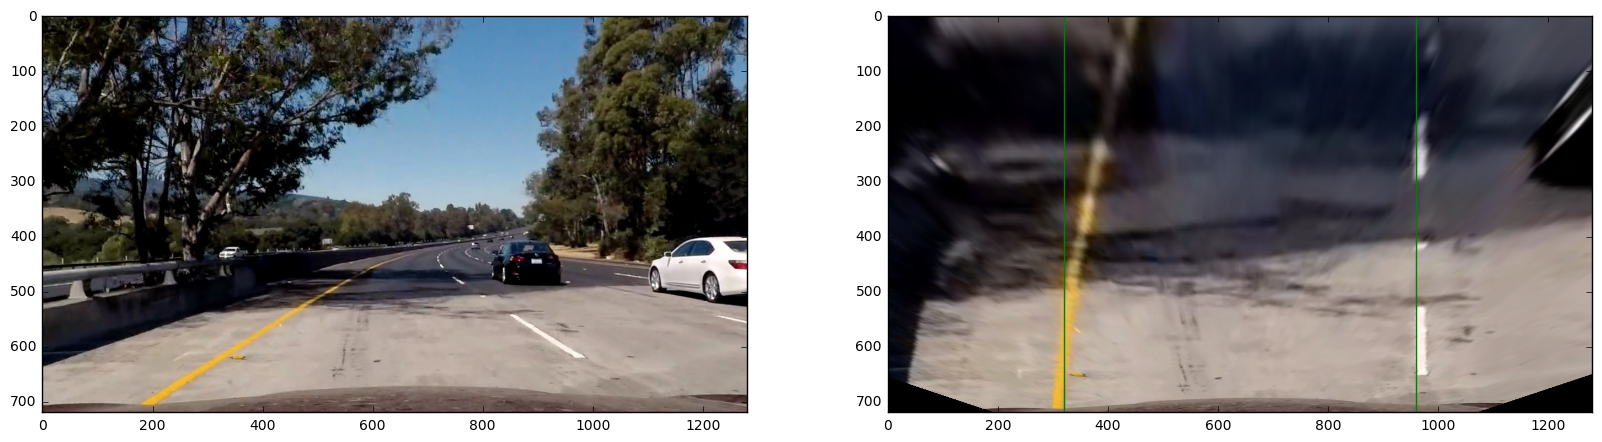

(720, 1280, 3) 960.0


In [77]:
# test perspective transform
def draw_region_of_interest(img, vertices):
    
    #vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)

    color = [0,255,0]
    
    left_bottom = (vertices[0][0][0], vertices[0][0][1])
    left_top = (vertices[0][1][0], vertices[0][1][1])
    right_top = (vertices[0][2][0], vertices[0][2][1])
    right_bottom = (vertices[0][3][0], vertices[0][3][1])

    bottom_center = ((right_bottom[0]+left_bottom[0])//2, right_bottom[1])
    top_center = ((right_top[0]+left_top[0])//2, right_top[1])

    
    cv2.line(img, left_bottom, left_top, color, 2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)
    #cv2.line(img, bottom_center, top_center, color, 2)
    
img = mpimg.imread('test_images/test5.jpg')
img = correct_distortion(img, mtx, dist)
shape = img.shape
src, dst = get_transform_points(shape)

#src = np.float32([
#        [shape[1]*.43958, shape[0]*.6389],
#        [shape[1]*.14583, shape[0]],
#       [shape[1]*.875,   shape[0]],
#        [shape[1]*.5625,  shape[0]*.6389]
#    ])
#dst = np.float32([
#        [shape[1]/4,0],
#        [shape[1]/4,shape[0]],
#        [shape[1]*3/4,shape[0]],
#        [shape[1]*3/4,0]
#    ])

#src = np.float32([
#    [shape[1]*.457, shape[0]*.6389],
#    [shape[1]*.1586, shape[0]],
#    [shape[1]*.880,  shape[0]],
#    [shape[1]*.543, shape[0]*.6389]
#])
#src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
#dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
#M = cv2.getPerspectiveTransform(src, dst)
#warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

warped = perspective_transform(img, src, dst)

#rgb = color_threshold(warped, 'R', (190,255)) & color_threshold(warped, 'G', (190,255)) & color_threshold(warped, 'B', (0,155)) 
#sobel = abs_sobel_threshold(warped, 'x', 17, (40,180))
#saturation = color_threshold(warped, 'L', (200,250))
#mask = np.zeros_like(sobel)
#mask[(sobel==1) | (saturation==1) | (rgb==1)] = 1

mask = do_thresholding(warped,1)



#draw_region_of_interest(img, [[(140,shape[0]),(422,345),(540,345),(840,shape[0])]])
#draw_region_of_interest(img,
#                        [[(np.int(shape[1]*.14583), shape[0]),
#                          (np.int(shape[1]*.43958), np.int(shape[0]*.6389)),
#                          (np.int(shape[1]*.5625),  np.int(shape[0]*.6389)),
#                          (np.int(shape[1]*.875),   shape[0])
#                         ]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))

ax1.imshow(img)
ax2.imshow(warped, cmap='gray')
ax2.axvline(shape[1]/4, color='g')
ax2.axvline(shape[1]*3/4, color='g')

plt.show();
print(shape,shape[1]*3/4)
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/perspective_transformation_1.png")

83.2216124132
86514


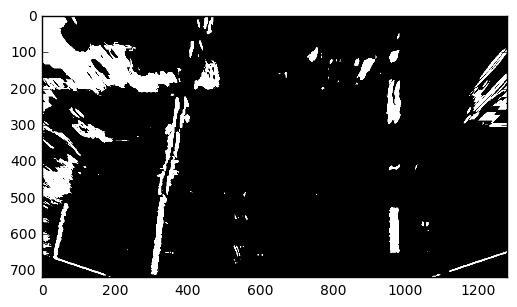

In [78]:
mask = do_thresholding(warped,1)
print(np.mean(warped))
print(np.sum(mask))
plt.imshow(mask,cmap='gray')
#mpimg.imsave("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/faulty_mask_2.png", result)

## Lane Line Histogram Test

[260, 334, 293] [913, 942, 927]


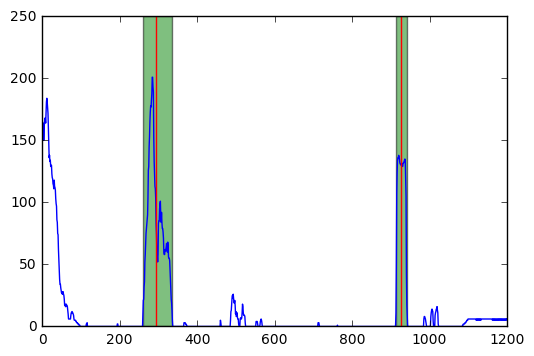

In [79]:

histogram = np.sum(mask[np.int(mask.shape[0]-mask.shape[0]/2):700,40:1240], axis=0)

left_line, right_line = find_line_positions(mask, histogram)
    
print(left_line, right_line)

fig = plt.figure()
plt.plot(histogram)
plt.axvspan(left_line[0], left_line[1], facecolor='g', alpha=0.5)
plt.axvline(left_line[2], color='r')
plt.axvspan(right_line[0], right_line[1], facecolor='g', alpha=0.5)
plt.axvline(right_line[2], color='r')

plt.show()
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/histogram_3.png")

## Sliding Through Image

[655 645 634 615 598 603 517 532]
[[260 285 273]
 [270 294 282]
 [278 313 293]
 [281 335 312]
 [299 365 327]
 [265 391 323]
 [317 447 404]
 [368 430 406]]
[[915 942 928]
 [914 940 927]
 [914 939 927]
 [912 943 927]
 [907 944 925]
 [907 945 926]
 [871 940 921]
 [935 941 938]]


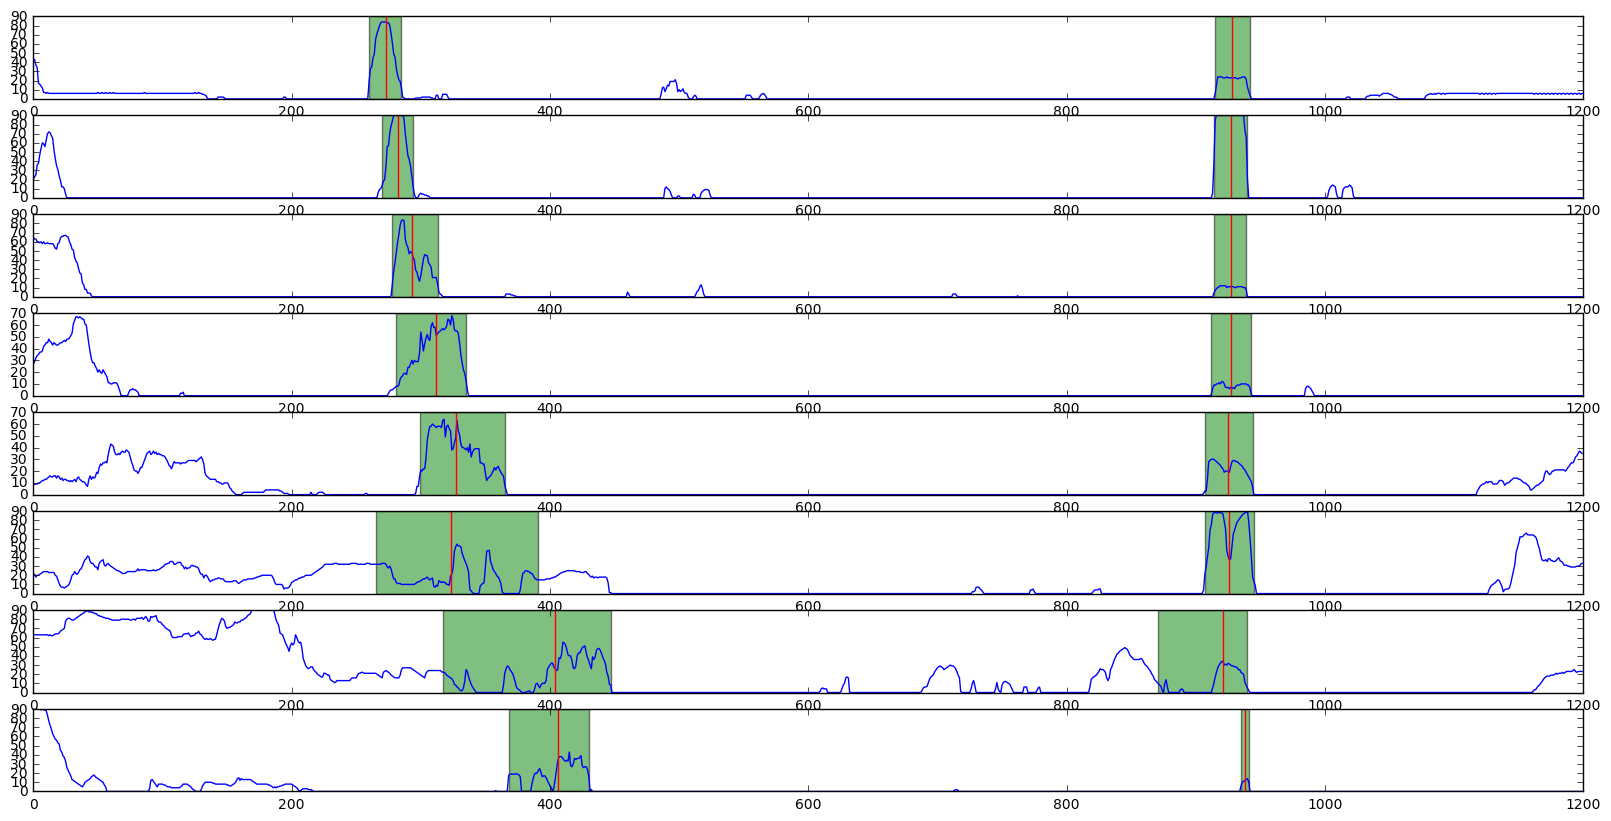

In [80]:

lane = np.array([630,720])
fig, axes = plt.subplots(8, 1, figsize=(20,10))

right_win = np.zeros((8,3),dtype='int')
left_win = np.zeros((8,3),dtype='int')

right_prev = right_line
left_prev = left_line

#right_prev = (910, 946, 928)
#left_prev = (300, 400, 350)


for i in range(8):
    
    h = np.sum(mask[lane[0]:lane[1],40:1240], axis=0) 
    
    right_win[i] = next_window_position(right_prev, lane, mask[:,40:1240])
    left_win[i] = next_window_position(left_prev, lane, mask[:,40:1240])

    axes[i].plot(h)

    if left_win[i,2] > 0:
        axes[i].axvline(left_win[i,2], color='r')
        axes[i].axvspan(left_win[i,0], left_win[i,1], facecolor='g', alpha=0.5)
    else:
        axes[i].axvspan(left_win[i,0], left_win[i,1], facecolor='r', alpha=0.5)
    
    if right_win[i,2] > 0:
        axes[i].axvline(right_win[i,2], color='r')
        axes[i].axvspan(right_win[i,0], right_win[i,1], facecolor='g', alpha=0.5)
    else:
        axes[i].axvspan(right_win[i,0], right_win[i,1], facecolor='r', alpha=0.5)

        
    right_prev = right_win[i]
    left_prev = left_win[i]
    lane = lane - 90
    
print(right_win[:,2]-left_win[:,2])
print(left_win)
print(right_win)

plt.show()
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/line_finding_3.png")

## Fitting to Polynomial

314 972


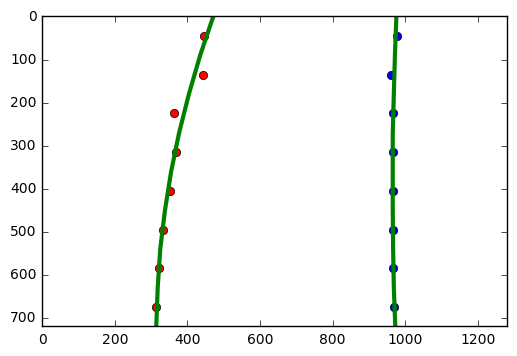

In [81]:


# Determine the curvature of the lane and vehicle position with respect to center.
left_fit = get_fit_data(left_win)
right_fit = get_fit_data(right_win)

# correct x-offset 
left_fit[:,0] = left_fit[:,0] + 40
right_fit[:,0] = right_fit[:,0] + 40

#print(left_fit, right_fit)

fig = plt.figure()

plt.plot(left_fit[:,0], left_fit[:,1], 'o', color='red')
plt.plot(right_fit[:,0], right_fit[:,1], 'o', color='blue')

yvals=np.array([0,90,180,270,360,450,540,630,720])

left_points, left_coef = fit_poly(left_fit, yvals)
right_points, right_coef = fit_poly(right_fit, yvals)

#print(left_points, right_points)

plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_points[:,0], left_points[:,1], color='green', linewidth=3)
plt.plot(right_points[:,0], right_points[:,1], color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

curverad = radius(left_points, right_points)

print(left_points[8,0], right_points[8,0])

plt.show();
#fig.savefig("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/polyfit_3.png")

314 972


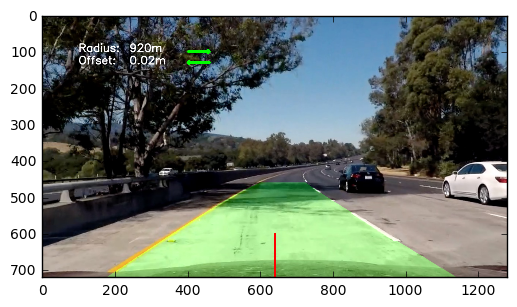

In [82]:
# Warp the detected lane boundaries back onto the original image.
overlay = make_lane_overlay(mask, left_points, right_points, src, dst)
    
result = cv2.addWeighted(img, 1, overlay, 0.3, 0)

offset = vehicle_offset(left_points[8,0], right_points[8,0])

cv2.putText(result, 'Radius:', (100,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
cv2.putText(result, 'Offset:', (100,134), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

text2 = "{0:.2f}".format(abs(offset)) + "m "
text1 = "{0:.0f}".format(abs(curverad)) + "m "

cv2.putText(result, text1, (240,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
cv2.putText(result, text2, (240,134), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)


cv2.arrowedLine(result, (400,100), (460,100), (0,255,0), 6)
cv2.line(result, (640,600), (640,720), (255,0,0), 4)
cv2.arrowedLine(result, (460,130), (400,130), (0,255,0), 6)


#cv2.putText(result, left_right(curverad), (360,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
#cv2.putText(result, left_right(offset),  (360,134), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

print(left_points[8,0], right_points[8,0])


plt.imshow(result);
#mpimg.imsave("/Users/olli/Udacity/SDC/P4/CarND-Advanced-Lane-Lines/output_images/nasty_lanes_2.png", result)

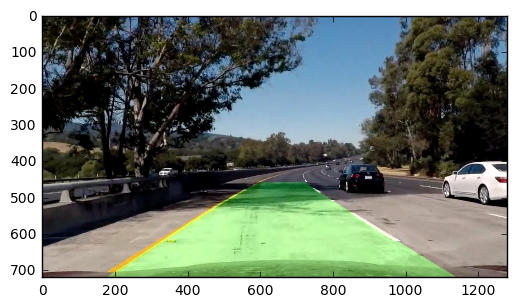

In [83]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(mask).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_points[:,0], left_points[:,1]]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_points[:,0], right_points[:,1]])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

plt.imshow(color_warp)

#src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
#dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
      
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
plt.imshow(result);

## Threshold Experimenting

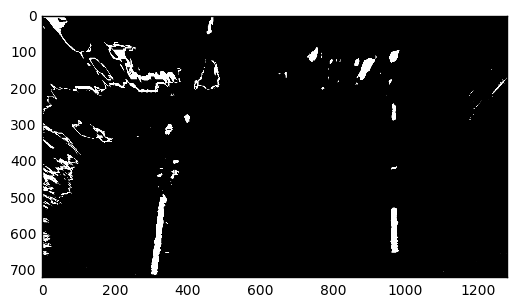

In [72]:
# test gradient combinations

#    rgb = color_threshold(img, 'R', (190,255))
#    rgb = rgb & color_threshold(img, 'G', (190,255)) 
#    rgb = rgb & color_threshold(img, 'B', (0,155))
#    sobel = abs_sobel_threshold(img, 'x', 17, (40,180))
#    luminance = color_threshold(img, 'L', (200,245))

from ipywidgets import widgets

def plt_gradx(sobel_mn, sobel_mx, ksize, color_mn, color_mx):
    #rgb = color_threshold(imgz, 'R', (200,255)) & color_threshold(imgz, 'G', (200,255)) & color_threshold(imgz, 'B', (200,255)) 
    rgb = color_threshold(imgz, 'B', (200,255)) 
    gradx = abs_sobel_threshold(imgz, orient='y', sobel_kernel=ksize, thresh=(sobel_mn,sobel_mx))
    col = color_threshold(imgz, 'S', (color_mn,color_mx))
    mask = np.zeros_like(col)
    #mask[(col==1) | (gradx==1)] = 1
    mask[((col==1) | (gradx==1) | (rgb==1))] = 1
    #mask[(rgb==1)] = 1
    f, ax = plt.subplots(1,1)
    ax.imshow(mask,cmap='gray');

#imgz = mpimg.imread('test_images/warped0.jpg')
imgz = warped
#print(np.mean(imgz))
widgets.interact(plt_gradx, sobel_mn=(0,255,1), sobel_mx=(0,255,1), ksize=(3,31,2), color_mn=(0,255), color_mx=(0,255))    

In [61]:
print(np.sum(mask))

524


## Colorspace Exploring

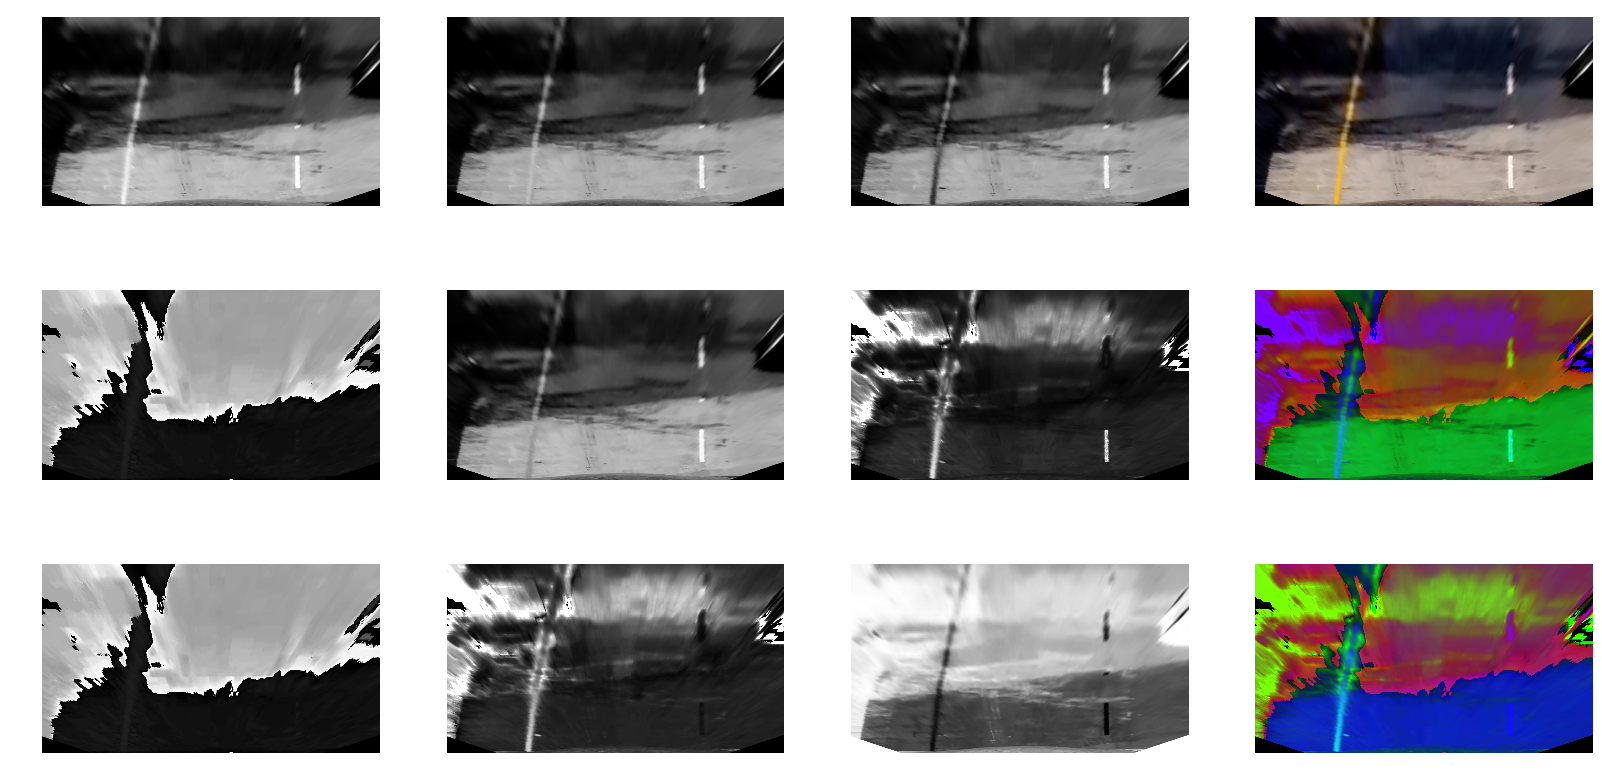

In [95]:
#img = mpimg.imread('test_images/warped4.jpg')
imgx = warped
fig, axes = plt.subplots(3, 4, figsize=(20,10))

axes[0,0].imshow(imgx[:,:,0], cmap='gray')
axes[0,0].axis('off')
axes[0,1].imshow(imgx[:,:,1], cmap='gray')
axes[0,1].axis('off')
axes[0,2].imshow(imgx[:,:,2], cmap='gray')
axes[0,2].axis('off')
axes[0,3].imshow(imgx)
axes[0,3].axis('off')

hls = cv2.cvtColor(imgx, cv2.COLOR_RGB2HLS)
axes[1,0].imshow(hls[:,:,0], cmap='gray')
axes[1,0].axis('off')
axes[1,1].imshow(hls[:,:,1], cmap='gray')
axes[1,1].axis('off')
axes[1,2].imshow(hls[:,:,2], cmap='gray')
axes[1,2].axis('off')
axes[1,3].imshow(hls)
axes[1,3].axis('off')

hsv = cv2.cvtColor(imgx, cv2.COLOR_RGB2HSV)
#hsv[:,:,1] = cv2.equalizeHist(img[:,:,1])
axes[2,0].imshow(hsv[:,:,0], cmap='gray')
axes[2,0].axis('off')
axes[2,1].imshow(hsv[:,:,1], cmap='gray')
axes[2,1].axis('off')
axes[2,2].imshow(255 - hsv[:,:,2], cmap='gray')
axes[2,2].axis('off')
axes[2,3].imshow(hsv, cmap='hsv')
axes[2,3].axis('off')

plt.show()